In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install sentencepiece
!pip install datasets
!pip install ml_things
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

     |████████████████████████████████| 4.0 MB 13.5 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |████████████████████████████████| 6.6 MB 42.4 MB/s 
     |████████████████████████████████| 880 kB 42.6 MB/s 
     |████████████████████████████████| 596 kB 48.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=2efd5f57408400f5bcae0708c34dc0502339ac431933f3776aaf0c2e58ba96e8
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 12.3 MB/s 
     |████████████████████████████████| 325 kB 12.1 MB/s 
     |████████████████████████████████| 212 kB 42.3 MB/s 
     |████████████████████████████████| 136 kB 52.8 MB/s 
     |████████████████████████████

Found existing installation: matplotlib 3.5.2
Uninstalling matplotlib-3.5.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.2
     |████████████████████████████████| 13.1 MB 8.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ml-things 0.0.1 requi

In [3]:
!pip install pytorch-lightning
!pip install wandb

     |████████████████████████████████| 584 kB 9.2 MB/s 
     |████████████████████████████████| 408 kB 25.9 MB/s 
     |████████████████████████████████| 1.8 MB 12.6 MB/s 
     |████████████████████████████████| 181 kB 53.3 MB/s 
     |████████████████████████████████| 144 kB 53.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=347e37de9cde7798b1ea37fbc4d344d2306501e6d491423124edae0b6b81868e
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
import wandb

wandb.init(project="CS505-GPT-neo-english", entity="divsp")

wandb: Currently logged in as: divsp (use `wandb login --relogin` to force relogin)


In [4]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          MT5Config,
                          AutoConfig,
                          AutoTokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          AutoModelForSequenceClassification,
                          AutoModel,
                          MT5ForConditionalGeneration)

# Set seed for reproducibility.
set_seed(123)

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 5

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 32

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 160

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
# model_name_or_path = 'sberbank-ai/mGPT'
model_name_or_path = 'EleutherAI/gpt-neo-125M'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = 20

/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.

## **Helper Functions**

I like to keep all Classes and functions that will be used in this notebook under this section to help maintain a clean look of the notebook:

<br>

**MovieReviewsDataset(Dataset)**

If you worked with PyTorch before, this is pretty standard. We need this class to read in our dataset, parse it and return texts with their associated labels.

In this class I only need to read in the content of each file, use fix_text to fix any Unicode problems and keep track of positive and negative sentiments.

I will append all texts and labels in lists.

There are three main parts of this PyTorch Dataset class:

* **init()** where we read in the dataset and transform text and labels into numbers.
* **len()** where we need to return the number of examples we read in. This is used when calling len(MovieReviewsDataset()).
* **getitem()** always takes as an input an int value that represents which example from our examples to return from our dataset. If a value of 3 is passed, we will return the example form our dataset at position 3.

<br>

**Gpt2ClassificationCollator**

I use this class to create the Data Collator. This will be used in the DataLoader to create the bathes of data that get fed to the model. I use the tokenizer and label encoder on each sequence to convert texts and labels to number.

Lucky for us, Hugging Face thought of everything and made the tokenizer do all the heavy lifting (split text into tokens, padding, truncating, encode text into numbers) and is very easy to use!

There are two main parts of this Data Collator class:

* **init()** where we initialize the tokenizer we plan to use, how to encode our labels and if we need to set the sequence length to a different value.

* **__call__()** used as function collator that takes as input a batch of data examples. It needs to return an object with the format that can be fed to our model. Luckily our tokenizer does that for us and returns a dictionary of variables ready to be fed to the model in this way: `model(**inputs)`. Since we are fine-tuning the model I also included the labels.





<br>

**train(dataloader, optimizer_, scheduler_, device_)**

I created this function to perform a full pass through the DataLoader object (the DataLoader object is created from our Dataset* type object using the **MovieReviewsDataset class). This is basically one epoch train through the entire dataset.

The dataloader is created from PyTorch DataLoader which takes the object created from MovieReviewsDataset class and puts each example in batches. This way we can feed our model batches of data!

The optimizer_ and scheduler_ are very common in PyTorch. They are required to update the parameters of our model and update our learning rate during training. There is a lot more than that but I won't go into details. This can actually be a huge rabbit hole since A LOT happens behind these functions that we don't need to worry. Thank you PyTorch!

In the process we keep track of the actual labels and the predicted labels along with the loss.

<br>

**validation(dataloader, device_)**

I implemented this function in a very similar way as train but without the parameters update, backward pass and gradient decent part. We don't need to do all of those VERY computationally intensive tasks because we only care about our model's predictions.

I use the DataLoader in a similar way as in train to get out batches to feed to our model.

In the process I keep track of the actual labels and the predicted labels along with the loss.


In [5]:
def read_from_file(filename):
    file = open(filename,"r")
    vocab = file.read().splitlines()
    return vocab

In [6]:
def save(model, path):
    # save
    torch.save(model.state_dict(), path)

In [7]:
class TwitterEmojiPrediction(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, data_path, label_path, use_tokenizer):

    self.texts = read_from_file(data_path)
    labels = read_from_file(label_path)
    self.labels = [int(label) for label in labels]
    self.n_examples = len(self.labels)
    

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}



class ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask. 
    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this 
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        # labels = [int(label) for label in labels]
        # labels = labels
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()
    wandb.log({"TrainLoss" : loss})

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer_.step()

    # Update the learning rate.
    scheduler_.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  save(model, '/content/drive/MyDrive/CS505-FinalProject/GPT-Neo/Outputs/GPT-Neo.cpkt')

  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]

        
        
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        wandb.log({"ValidLoss" : loss})
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

## **Load Model and Tokenizer**

Loading the three essential parts of the pretrained GPT2 transformer: configuration, tokenizer and model. 

For this example I will use `gpt2` from HuggingFace pretrained transformers. You can use any variations of GP2 you want.

In creating the `model_config` I will mention the number of labels I need for my classification task. Since I only predict two sentiments: positive and negative I will only need two labels for `num_labels`.

Creating the `tokenizer` is pretty standard when using the Transformers library. After creating the tokenizer it is critical for this tutorial to set padding to the left `tokenizer.padding_side = "left"` and initialize the padding token to `tokenizer.eos_token` which is the GPT2's original end of sequence token. This is the most essential part of this tutorial since GPT2 uses the last token for prediction so we need to pad to the left.

HuggingFace already did most of the work for us and added a classification layer to the GPT2 model. In creating the model I used `GPT2ForSequenceClassification`.
Since we have a custom padding token we need to initialize it for the model using `model.config.pad_token_id`.
Finally we will need to move the model to the device we defined earlier.



In [8]:
from transformers import AutoModelForCausalLM
# Get model configuration.
print('Loading configuraiton...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
# model = AutoModelForCausalLM("mt5", "google/mt5-small", config=model_config)
# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...


Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

Loading tokenizer...


Downloading:   0%|          | 0.00/560 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/357 [00:00<?, ?B/s]

Loading model...


Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['transformer.h.11.attn.attention.bias', 'transformer.h.5.attn.attention.bias', 'transformer.h.7.attn.attention.bias', 'transformer.h.3.attn.attention.bias', 'transformer.h.9.attn.attention.bias', 'transformer.h.1.attn.attention.bias', 'score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


## **Dataset and Collator**

This is where I create the PyTorch Dataset and Data Loader with Data Collator objects that will be used to feed data into our model.

This is where I use the **MovieReviewsDataset** class to create the PyTorch Dataset that will return texts and labels.

Since we need to input numbers to our model we need to convert the texts and labels to numbers. This is the purpose of a collator! It takes data outputted by the PyTorch Dataset and passed through the Data Collator function to output the sequence for our model.

I'm keeping the tokenizer away from the PyTorch Dataset to make the code cleaner and better structured. You can obviously use the tokenizer inside the PyTorch Dataset and output sequences that can be used straight into the model without using a Data Collator.

I strongly recommend to use a validation text file in order to determine how much training is needed in order to avoid overfitting. After you figure out what parameters yield the best results, the validation file can be incorporated in train and run a final train with the whole dataset.

The data collator is used to format the PyTorch Dataset outputs to match the inputs needed for GPT2.

In [9]:
# Create data collator to encode text and labels into numbers.
classificaiton_collator = ClassificationCollator(use_tokenizer=tokenizer,  
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
en_train_data_path = "/content/drive/MyDrive/CS505-FinalProject/train/english/tweet_by_ID_30_4_2022__04_17_45.txt.text"
en_train_labels_path = "/content/drive/MyDrive/CS505-FinalProject/train/english/tweet_by_ID_30_4_2022__04_17_45.txt.labels"

train_dataset = TwitterEmojiPrediction(en_train_data_path, en_train_labels_path, 
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  TwitterEmojiPrediction('/content/drive/MyDrive/CS505-FinalProject/test/us_test.text', 
                                        '/content/drive/MyDrive/CS505-FinalProject/test/us_test.labels',
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...
Created `train_dataset` with 385275 examples!
Created `train_dataloader` with 12040 batches!

Dealing with Validation...
Created `valid_dataset` with 50000 examples!
Created `eval_dataloader` with 1563 batches!


In [ ]:
train_dataloader.dataset.labels

## **Train**

I created optimizer and scheduler use by PyTorch in training. I used most common parameters used by transformers models.

I looped through the number of defined epochs and call the **train** and **validation** functions.

I'm trying to output similar info after each epoch as Keras: *train_loss:  - val_loss:  - train_acc: - valid_acc*.

After training, plot train and validation loss and accuracy curves to check how the training went.

**Note:** *The training plots might look a little weird: The validation accuracy starts higher than training accuracy and the validation loss starts lower than the training loss. Normally this will be the opposite. I assume the data split just happen to be easier for the validation part or too hard for training part or both. Since this tutorial is about using GPT2 for classification I will not worry about the results of the model too much.*

Epoch


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/5 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/12040 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1563 [00:00<?, ?it/s]

  train_loss: 2.51147 - val_loss: 2.47087 - train_acc: 0.25008 - valid_acc: 0.26694


Training on batches...


  0%|          | 0/12040 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1563 [00:00<?, ?it/s]

  train_loss: 2.43995 - val_loss: 2.43770 - train_acc: 0.27603 - valid_acc: 0.28046


Training on batches...


  0%|          | 0/12040 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1563 [00:00<?, ?it/s]

  train_loss: 2.39845 - val_loss: 2.42103 - train_acc: 0.28751 - valid_acc: 0.28440


Training on batches...


  0%|          | 0/12040 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1563 [00:00<?, ?it/s]

  train_loss: 2.37543 - val_loss: 2.41353 - train_acc: 0.29535 - valid_acc: 0.28922


Training on batches...


  0%|          | 0/12040 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1563 [00:00<?, ?it/s]

  train_loss: 2.35377 - val_loss: 2.41046 - train_acc: 0.30056 - valid_acc: 0.29162



/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


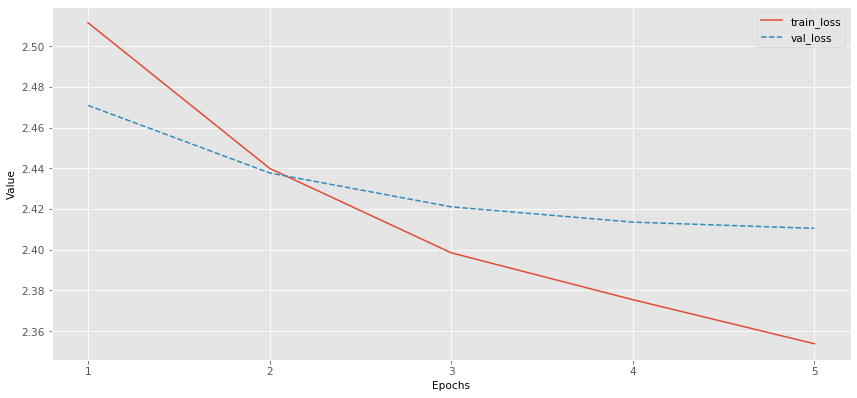

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


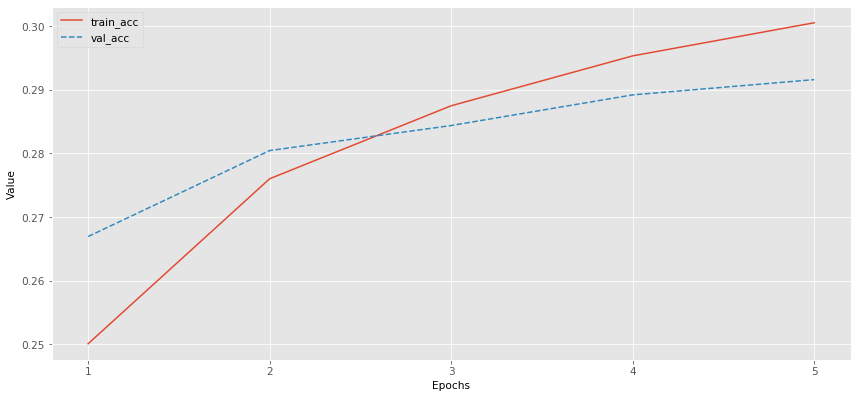

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 0.001, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  wandb.log({"train_acc" : train_acc})
  wandb.log({"train_loss" : train_loss})
  wandb.log({"val_acc" : val_acc})
  wandb.log({"val_loss" : val_loss})

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

## **Evaluate**

When dealing with classification is useful to look at precision recall and F1 score.

A good gauge to have when evaluating a model is the confusion matrix.

In [ ]:
import numpy as np
np.arange(0, 5)

array([0, 1, 2, 3, 4])

In [ ]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create the evaluation report.
# label_path='/content/drive/MyDrive/505/Project Data/test/us_test.labels'
# labels = read_from_file(label_path)
evaluation_report = classification_report(true_labels, predictions_labels)
# Show the evaluation report.
print(evaluation_report)

# # Plot confusion matrix.
# classes = set(true_labels)
# plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
#                       classes=classes, normalize=True, 
#                       magnify=0.1,
#                       );

  0%|          | 0/1563 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.32      0.82      0.46     10798
           1       0.20      0.24      0.22      4830
           2       0.20      0.42      0.27      4534
           3       0.33      0.00      0.00      2605
           4       0.41      0.29      0.34      3716
           5       0.08      0.00      0.01      1613
           6       0.10      0.03      0.04      1996
           7       0.16      0.02      0.04      2749
           8       0.00      0.00      0.00      1549
           9       0.00      0.00      0.00      1175
          10       0.22      0.24      0.23      1432
          11       0.50      0.20      0.28      1949
          12       0.54      0.18      0.27      1265
          13       0.00      0.00      0.00      1114
          14       0.12      0.00      0.00      1306
          15       0.00      0.00      0.00      1244
          16       0.00      0.00      0.00      1153
          17       0.57    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
val_acc = accuracy_score(true_labels, predictions_labels)
val_acc

0.17

In [ ]:
len(set(predictions_labels))

7

In [10]:
def flat_accuracy_topk(preds, labels, topk):
    count = 0
    labels_flat = labels.flatten()
    for i in range(len(preds)):
      logits = preds[i].argsort()[::-1][:topk]
      if labels[i] in logits:
        count += 1
    return count / len(labels_flat)

def validation_topk(model, dataloader, device_, topk):

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0
  total_eval_accuracy = 0

  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    with torch.no_grad():        

        outputs = model(**batch)
        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        total_loss += loss.item()
        label_ids = batch['labels'].to('cpu').numpy()

        total_eval_accuracy += flat_accuracy_topk(logits, label_ids, topk)
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  total_acc = total_eval_accuracy /len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss, total_acc

In [11]:
model.load_state_dict(torch.load('/content/drive/MyDrive/CS505-FinalProject/GPT-Neo/Outputs/GPT-Neo.cpkt'))
validation_topk(model, valid_dataloader, device, 3)

  0%|          | 0/1563 [00:00<?, ?it/s]

([2,
  10,
  6,
  1,
  16,
  17,
  4,
  10,
  12,
  18,
  0,
  1,
  5,
  7,
  7,
  4,
  0,
  7,
  0,
  10,
  2,
  0,
  0,
  0,
  14,
  3,
  4,
  0,
  6,
  13,
  18,
  18,
  5,
  1,
  11,
  0,
  18,
  13,
  0,
  4,
  0,
  1,
  0,
  4,
  18,
  0,
  16,
  4,
  1,
  1,
  11,
  13,
  2,
  16,
  1,
  0,
  18,
  2,
  2,
  10,
  6,
  6,
  4,
  2,
  1,
  4,
  6,
  18,
  7,
  12,
  10,
  1,
  1,
  0,
  12,
  2,
  1,
  7,
  6,
  7,
  6,
  0,
  0,
  18,
  5,
  17,
  0,
  8,
  7,
  0,
  0,
  0,
  10,
  5,
  0,
  0,
  0,
  0,
  7,
  7,
  0,
  2,
  0,
  1,
  4,
  18,
  17,
  7,
  0,
  14,
  17,
  1,
  3,
  0,
  0,
  13,
  0,
  4,
  14,
  7,
  18,
  0,
  0,
  0,
  6,
  1,
  8,
  2,
  3,
  3,
  6,
  9,
  18,
  11,
  7,
  2,
  5,
  7,
  0,
  18,
  18,
  14,
  6,
  3,
  1,
  15,
  13,
  2,
  8,
  16,
  14,
  14,
  4,
  10,
  1,
  6,
  12,
  0,
  1,
  3,
  1,
  2,
  2,
  11,
  7,
  14,
  0,
  18,
  0,
  9,
  1,
  0,
  7,
  6,
  0,
  2,
  16,
  2,
  1,
  6,
  1,
  10,
  4,
  12,
  16,
  3,
  6,
  8,
  7,
 